<a href="https://www.kaggle.com/code/aisuko/efficient-ways-on-generate-images?scriptVersionId=164206552" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Overview

Generating something out of nothing is a computationally internsive process, especially if you're running inference over and over again wihtout less powerful computing resources. This is why it's important to get the most computational(speed) and memory(GPU RAM) efficiently from the pipline to reduce the time between inference cycles so we can iterate faster. This notebook container how to generate faster and better with the Diffusion pipeline.

In [1]:
%%capture
!pip install diffusers==0.26.3
# ImportError: cannot import name 'CpuOffload' from 'accelerate.hooks'
!pip install transformers==4.38.1
!pip install accelerate==0.27.2

In [2]:
import os
import torch

os.environ['MODEL_NAME']='runwayml/stable-diffusion-v1-5'

if torch.cuda.is_available():
    torch_device = 'cuda'
else:
    torch_device = 'cpu'

print(torch_device)

cuda


In [3]:
# For supporting mac silicon if you change torch_device to `mps`
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

# Loading the Stable Diffusion model

In [4]:
from diffusers import DiffusionPipeline

pipeline = DiffusionPipeline.from_pretrained(os.getenv('MODEL_NAME'),torch_dtype=torch.float16)
pipeline.to(torch_device)
print(pipeline)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.26.3",
  "_name_or_path": "runwayml/stable-diffusion-v1-5",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}



# Inference

1. One of the simplest wat to speed up infernece is to palce the pipeline on a GPU.
2. To make sure you can use the same image and improve on it, use a *Generator* and set a speed for *reproducibility*.
3. Reducing the number of inference steps.

Let's try to generate an image:

In [5]:
generator = torch.Generator(device=torch_device).manual_seed(0)
print(generator)

In [6]:
prompt = "Abstract watercolor painting of village, magic diamond crystal winter, cinematic light, national romanticism by Anders Zorn, by Greg Rutkowski, by Greg Manchess"

image = pipeline(prompt, generator=generator).images[0]
print(image)

  0%|          | 0/50 [00:00<?, ?it/s]

<PIL.Image.Image image mode=RGB size=512x512 at 0x7AAF4E850430>


This process took ~30s on a T4 GPU(from official document), 43.2s from M1 GPU. By default, the DiffusionPipeline runs inference with full float32 precision for 50 inference steps. We can speed up by switching to a lower precision like float16 or running fewer inference steps. For example we load the model in float16 and generate an image [Generating by f16](https://www.kaggle.com/code/aisuko/generating-an-image-with-f16?kernelSessionId=135390061).

Choosing a more efficient scheduler could help decrease the number of steps without sacrificing outout quality. Example for find the schedulers are compatible with the current model in the DiffusionPipeline by calling the compatibles method:

In [7]:
pipeline.scheduler.compatibles

[diffusers.schedulers.scheduling_ddpm.DDPMScheduler,
 diffusers.schedulers.scheduling_unipc_multistep.UniPCMultistepScheduler,
 diffusers.schedulers.scheduling_lms_discrete.LMSDiscreteScheduler,
 diffusers.schedulers.scheduling_dpmsolver_multistep.DPMSolverMultistepScheduler,
 diffusers.schedulers.scheduling_k_dpm_2_discrete.KDPM2DiscreteScheduler,
 diffusers.schedulers.scheduling_k_dpm_2_ancestral_discrete.KDPM2AncestralDiscreteScheduler,
 diffusers.schedulers.scheduling_euler_ancestral_discrete.EulerAncestralDiscreteScheduler,
 diffusers.schedulers.scheduling_euler_discrete.EulerDiscreteScheduler,
 diffusers.schedulers.scheduling_dpmsolver_singlestep.DPMSolverSinglestepScheduler,
 diffusers.schedulers.scheduling_heun_discrete.HeunDiscreteScheduler,
 diffusers.utils.dummy_torch_and_torchsde_objects.DPMSolverSDEScheduler,
 diffusers.schedulers.scheduling_pndm.PNDMScheduler,
 diffusers.schedulers.scheduling_deis_multistep.DEISMultistepScheduler,
 diffusers.schedulers.scheduling_ddim.DDI

The stable Diffusion model uses the `PNDMScheduler` by `default` which usually requires `~50 inference steps`, but more performant schedulers like `DPMSolverMultistepScheduler`, require only `~20 or 25` inference steps. Use the `ConfigMixin.from_config()` method to load a new scheduler:

In [8]:
from diffusers import DPMSolverMultistepScheduler

pipeline.scheduler = DPMSolverMultistepScheduler.from_config(pipeline.scheduler.config)

  0%|          | 0/20 [00:00<?, ?it/s]

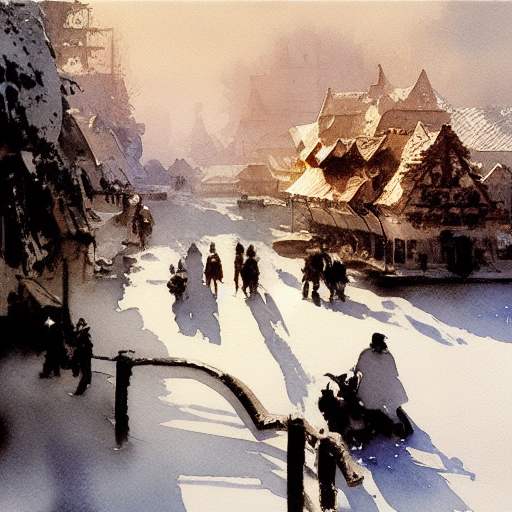

In [9]:
generator = torch.Generator(device=torch_device).manual_seed(0)
# set the num_inference_steps to 20
image = pipeline(prompt, generator=generator,num_inference_steps=20).images[0]
image

# Consuming Less Memory

The other key to improve pipeline performance is consuming less memory, which indirectly implies more speed, since you'are often trying to maximize the number of images generated per second. The eaisest way to see how many images you can generate at once is to try out different batch sizes until you get an OutOfMemoryError.

Create a function that will generate a batch of imges from a list of prompts and Generators. Make sure to assign each Generator a seed so you can resuse it if it produces a good result.

In [10]:
def get_inputs(batch_size=1):
    generator = [torch.Generator(device=torch_device).manual_seed(i) for i in range(batch_size)]
    prompts=batch_size*[prompt]
    num_inference_steps=20

    return {"prompt":prompts,"generator":generator,"num_inference_steps":num_inference_steps}

You will also need a function that will display each batch of images:

In [11]:
from PIL import Image

def image_grid(imgs, rows=2, cols=2):
    w, h =imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

Start with `batch_size=4` and see how much memory you've consumed. Insted of running this operation in a batch, you can run it sequentially to save a significant amount of memory by using the `enable_attention_slicing` function:

In [12]:
pipeline.enable_attention_slicing()

  0%|          | 0/20 [00:00<?, ?it/s]

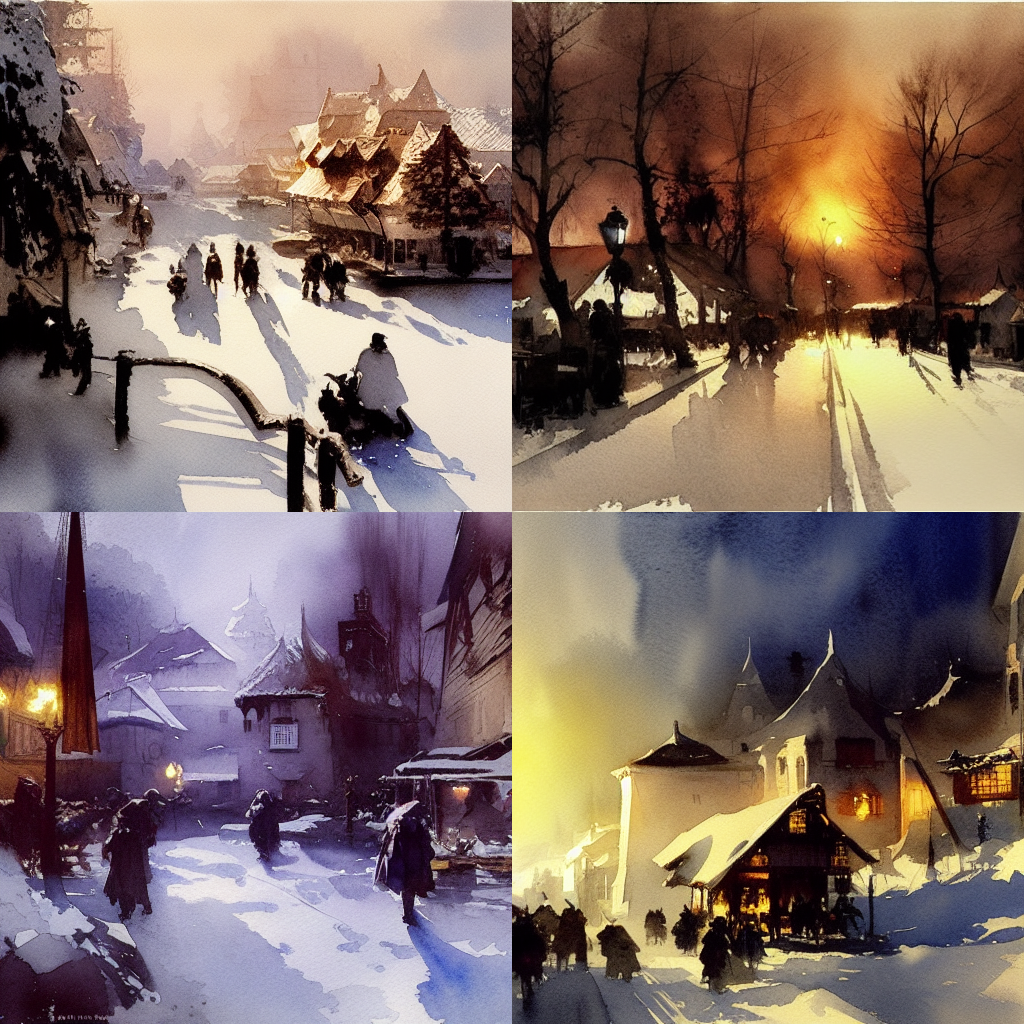

In [13]:
images = pipeline(**get_inputs(4)).images
image_grid(images)

# Improving the Image Quality

Let's going to focus on how to improve the quality of generated images.


## Better checkpoints

The most obvious step is to use better checkpoints. The Stable Diffusion model is good starting point, and since its official launch, several improved versions have also been released. However, using a newer version doesn't automatically mean you will get better results. You will still have to experiement with different checkpoints yourself, and do a little research(sych as using negative prompts) to get the best results.

As the filed grows, there are more and more high-quality checkpoints finetuned to produce certain styles. [Models Hub](https://huggingface.co/models?library=diffusers&sort=downloads) and [Diffusers Gallery](https://huggingface.co/spaces/huggingface-projects/diffusers-gallery)


## Better pipelines components

We can also try replacing the current pipelline components with a newer version. For example, loading the latest autodecoder from Stability AI into the pipeline, and generate some images:

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

  0%|          | 0/20 [00:00<?, ?it/s]

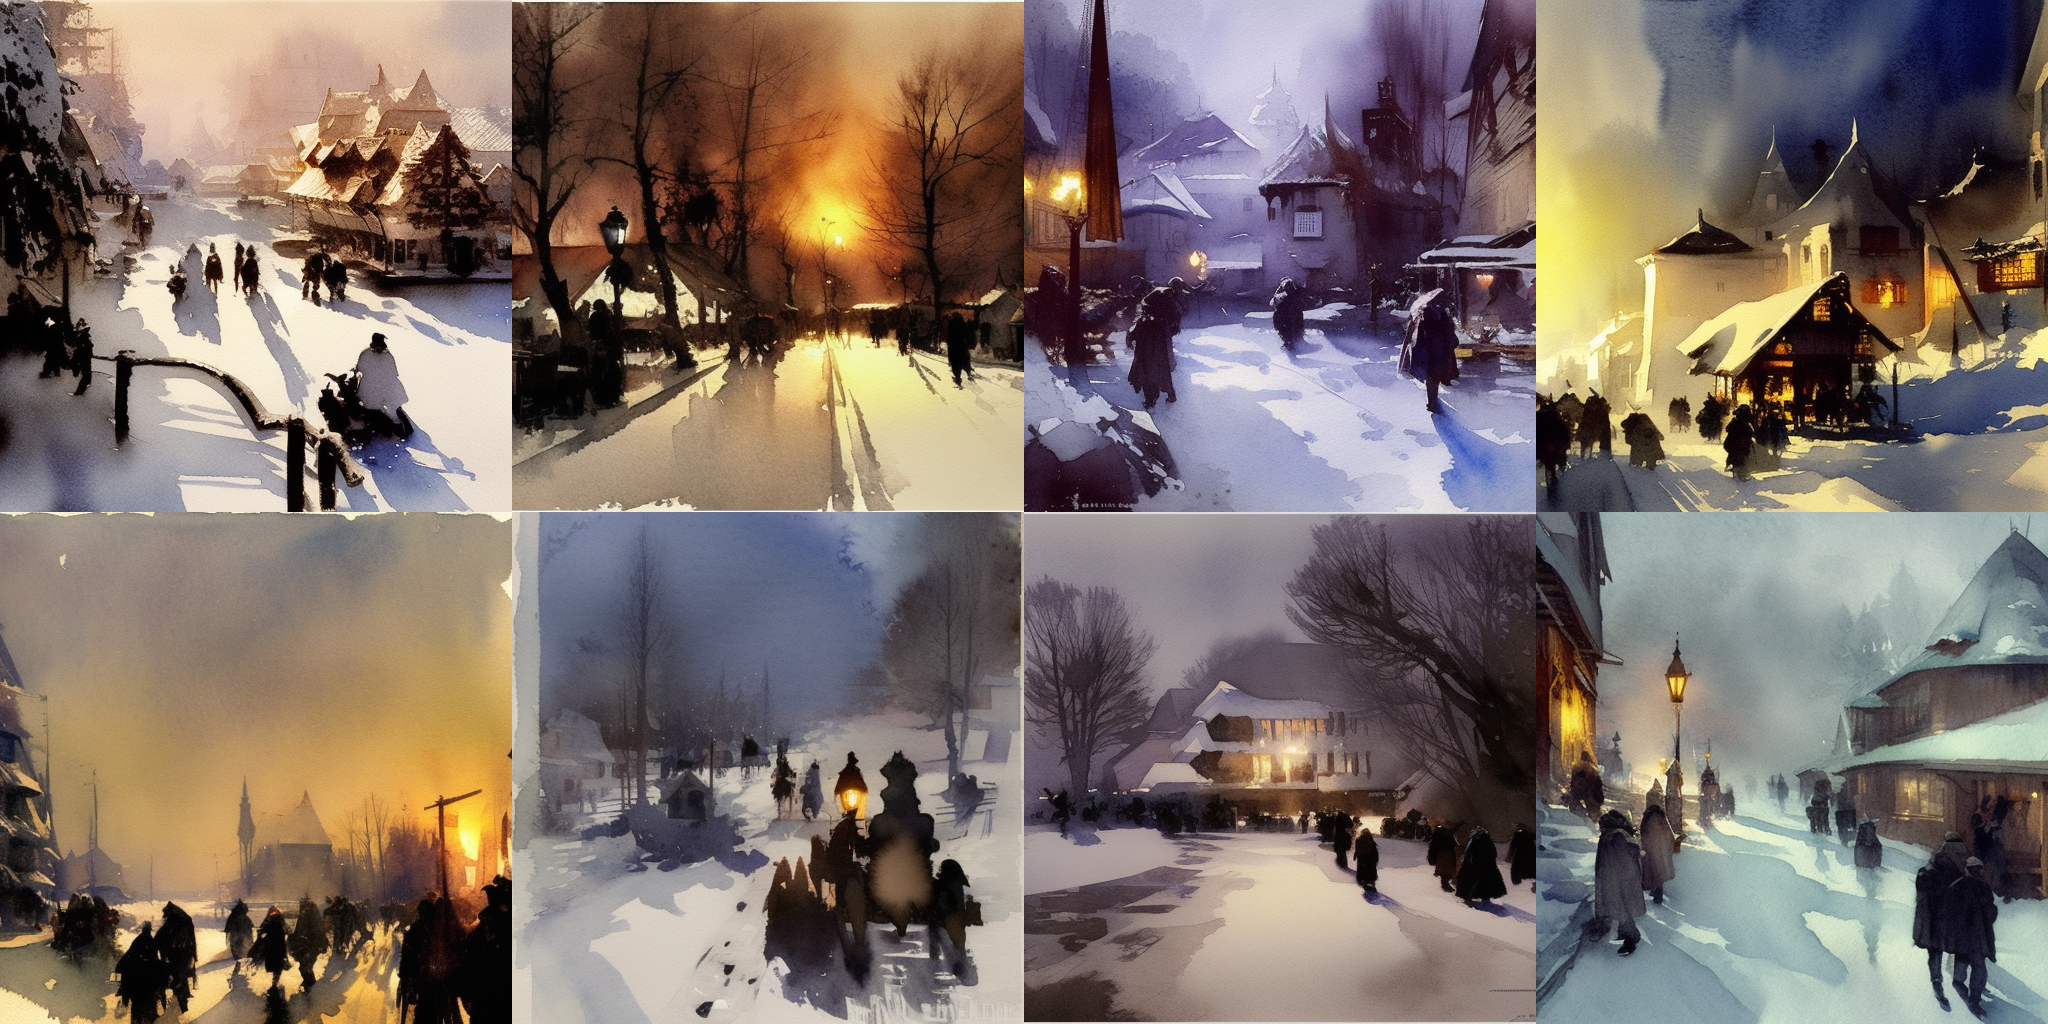

In [14]:
from diffusers import AutoencoderKL

vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse",torch_dtype=torch.float16).to(torch_device)

pipeline.vae = vae

images = pipeline(**get_inputs(8)).images
image_grid(images,rows=2,cols=4)